In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df=pd.read_csv('/content/fremont-bridge.csv')

In [ ]:
df.head()

,Date,West,East
0,10-03-2012 00:00,4.0,9.0
1,10-03-2012 01:00,4.0,6.0
2,10-03-2012 02:00,1.0,1.0
3,10-03-2012 03:00,2.0,3.0
4,10-03-2012 04:00,6.0,1.0


In [ ]:
df.tail()

,Date,West,East
45979,12-31-2017 19:00,9.0,12.0
45980,12-31-2017 20:00,6.0,8.0
45981,12-31-2017 21:00,3.0,10.0
45982,12-31-2017 22:00,7.0,6.0
45983,12-31-2017 23:00,7.0,9.0


In [ ]:
df['Total']=df['East']+df['West']

In [ ]:
df.drop(["West","East"],axis=1,inplace=True)

In [ ]:
df.isnull().sum()

Date     0
Total    8
dtype: int64

In [ ]:
df.fillna(method='ffill', inplace=True)

In [ ]:
df.isnull().sum()

Date     0
Total    0
dtype: int64

In [ ]:
df1=df.reset_index()['Total']

In [ ]:
df1

0        13.0
1        10.0
2         2.0
3         5.0
4         7.0
         ... 
45979    21.0
45980    14.0
45981    13.0
45982    13.0
45983    16.0
Name: Total, Length: 45984, dtype: float64

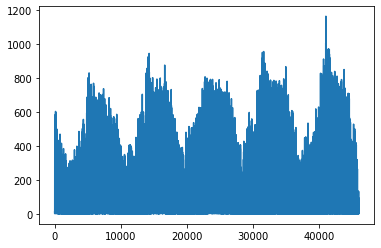

In [ ]:
plt.plot(df1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.0111588 ]
 [0.00858369]
 [0.00171674]
 ...
 [0.0111588 ]
 [0.0111588 ]
 [0.01373391]]


# splitting dataset into train and test split

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(29889, 16095)

In [ ]:
train_data

array([[0.0111588 ],
       [0.00858369],
       [0.00171674],
       ...,
       [0.06523605],
       [0.18712446],
       [0.28497854]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(29788, 100)
(29788,)


(None, None)

In [ ]:
print(X_test.shape), print(y_test.shape)

(15994, 100)
(15994,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
466/466 [==============================] - 91s 184ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 2/10
466/466 [==============================] - 86s 184ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/10
466/466 [==============================] - 85s 183ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 4/10
466/466 [==============================] - 86s 184ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/10
466/466 [==============================] - 85s 183ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 6/10
466/466 [==============================] - 85s 182ms/step - loss: 7.2726e-04 - val_loss: 8.7524e-04
Epoch 7/10
466/466 [==============================] - 85s 182ms/step - loss: 6.2172e-04 - val_loss: 9.9772e-04
Epoch 8/10
466/466 [==============================] - 85s 182ms/step - loss: 5.5090e-04 - val_loss: 6.9333e-04
Epoch 9/10
466/466 [==============================] - 85s 183ms/step - loss: 5.1841e-04 - val_loss: 6.9465e-04
Epoch 10/10
466/466 [====================

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

176.82773803270194

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

197.98566717349448

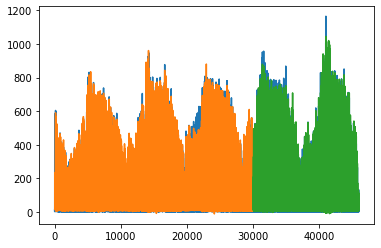

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Evaluation of the LSTM model

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
def eval(y_true,y_predicted):
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    return mae,rmse,mape

In [ ]:
mae,rmse,mape=eval(y_test,test_predict)
print("MAE = {} ; RMSE = {} ; MAPE = {}".format(mae,rmse,mape))

MAE = 130.64670973295623 ; RMSE = 197.98566717349448 ; MAPE = 745876902481255.6
